In [771]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve
from sklearn.inspection import DecisionBoundaryDisplay
from time import perf_counter

In [772]:
def select_random_points(img, n=100):
    X,Y = np.shape(img)
    x_sample, y_sample = random.sample(range(X), n), random.sample(range(Y), n)
    
    return tuple(zip(x_sample, y_sample))

In [773]:
def sdev_area(img, x, y, r):
    if x - r < 0 or y - r < 0 or x + r >= img.shape[0] or y + r >= img.shape[1]:
        return None
    
    testarea = img[x - r: x + r, y - r: y + r]
    return np.std(testarea)

def slope_area(img, x, y, r):
    if x - r < 0 or y - r < 0 or x + r >= img.shape[0] or y + r >= img.shape[1]:
        return None
    
    testarea = img[x - r: x + r, y - r: y + r]
    
    xgrid, ygrid = np.meshgrid(range(-r, r), range(-r, r))
    
    #this defines the X vector to perform Linear Regression using least squares method
    # Ax + By + C = z
    # so X[:,0] is all the multipliers of A, X[:,1] is all the multipliers of B, X[:,2] is all 1s because C has constant multipliers
    X = np.stack([xgrid.ravel(), ygrid.ravel()], axis=1)
    X = np.hstack([X, np.ones((X.shape[0], 1))])

    #this defines the y vector to perform Linear Regression (however y is taken so i am using Z)
    Z = testarea.ravel()

    coeffs, _, _, _ = np.linalg.lstsq(X, Z, rcond=None)
    
    A, B, C = coeffs
    slope = np.sqrt(A**2 + B**2)
    
    return slope

In [774]:
img = np.load("depth_sample/6.npy")

t1 = perf_counter()

r = 60
slope_cutoff = 0.01
roughness_cutoff = 0.1

points = np.array(select_random_points(img, n=500))
points_landable = np.zeros_like(points[:,0])
img_circle = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

for idx, (px, py) in enumerate(points):
    slope = slope_area(img, px, py, r)
    roughness = sdev_area(img, px, py, r)
    
    color = (255,0,0)
    if slope is not None and roughness is not None:
        color = (255, 0, 0)
        
        if (slope <= slope_cutoff) and (roughness <= roughness_cutoff):
            color = (0, 255, 120)
            points_landable[idx] = 1
    
    img_circle = cv2.circle(img_circle, (py, px), int(r/5), color, 5)

t2 = perf_counter()

In [775]:
SVM_model = SVC(kernel="rbf")
C_regularization = np.logspace(-3.5, 2.5, 10)

train_score, val_score = validation_curve(
    estimator = SVM_model,
    X = points,
    y = points_landable,
    param_name = "C",
    param_range = C_regularization,
    cv = 5
)

mean_val_score = np.mean(val_score, axis=1)
best_C = C_regularization[np.argmax(mean_val_score)]

print(best_C)

316.22776601683796


In [776]:
points_xinv = np.concatenate([points[:,1:], points[:,0:1]], axis=1)

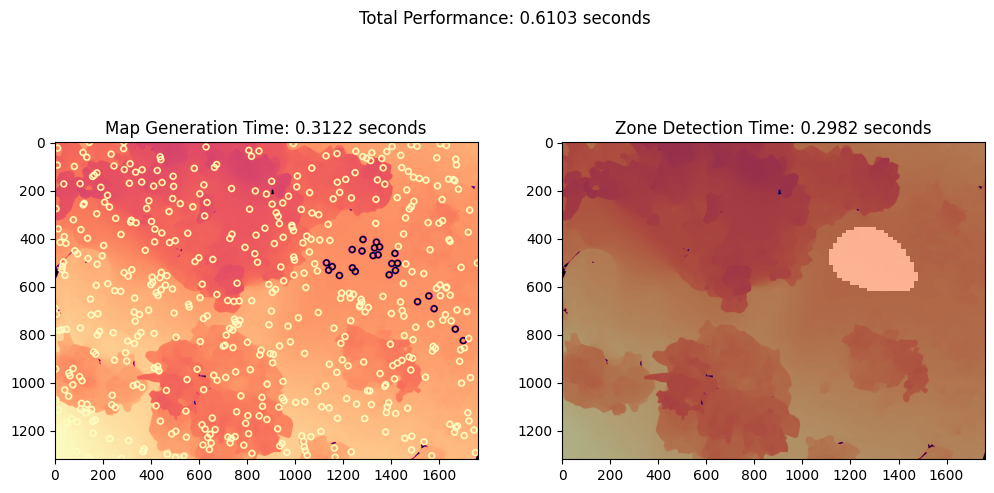

In [777]:
landing_classifier = SVC(kernel='rbf', C=best_C).fit(points_xinv, points_landable)

t3 = perf_counter()

fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))

DecisionBoundaryDisplay.from_estimator(
    estimator=landing_classifier,
    X=points_xinv,
    ax=ax2,
    response_method="predict",
    plot_method="pcolormesh",
    alpha=0.3,
    cmap='gray'
)

ax2.invert_yaxis()
ax2.imshow(img, cmap='magma')
ax2.set_title(f"Zone Detection Time: {t3 - t2:.4f} seconds")

ax1.imshow(img_circle, cmap='magma')
ax1.set_title(f"Map Generation Time: {t2 - t1:.4f} seconds")

plt.suptitle(f"Total Performance: {t3 - t1:.4f} seconds")
plt.show()

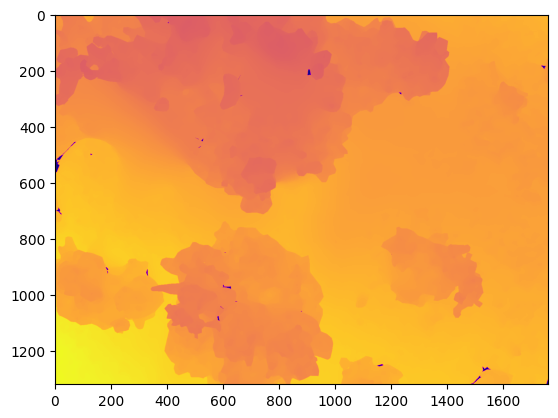

In [778]:
plt.imshow(img, cmap='plasma')
plt.show()